In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [3]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = XY.loc[XY['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.15)
trainXY.shape

(10972, 20)

In [4]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [5]:
trainXY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
51600,457.59,5905.618876,0.711,candu19,phwr,0.000127,0.1407,0.1394,2.092000e-07,0.04185,0.08877,0.003385,0.000005,0.4499,0.002683,0.000009,6.210000e-08,0.009892,0.01278,0.006949
32895,7759.88,3153.315642,3.740,vver1000,pwr,0.010380,2.2800,2.2620,3.477000e-03,0.58500,1.75800,0.105200,0.005109,13.7800,1.996000,0.570700,6.290000e-02,0.019170,0.40260,0.203100
10668,3189.70,1433.054598,3.690,ce14x14,pwr,0.002297,0.9499,0.9487,2.762000e-03,0.23520,0.80810,0.032080,0.001240,7.0280,0.488400,0.076360,2.607000e-03,0.017060,0.14780,0.072050
44397,2602.55,2911.481358,3.630,agr,agr,0.001863,0.7854,0.7835,4.064000e-04,0.35390,0.60260,0.023580,0.000503,4.0290,0.336400,0.030090,1.272000e-03,0.010940,0.12180,0.055350
48660,7316.84,551.732105,3.630,agr,agr,0.010640,2.1830,2.1650,2.586000e-02,0.99250,1.94400,0.089050,0.006341,7.8340,1.648000,0.532700,5.189000e-02,0.012060,0.37410,0.191400
56710,5200.17,823.662780,0.711,candu19,phwr,0.003058,1.5880,1.5690,5.270000e-03,0.43050,1.37900,0.045120,0.002110,4.3000,0.378100,0.029820,1.455000e-03,0.010960,0.24890,0.141700
20969,4135.34,4167.713975,2.990,vver1000,pwr,0.003395,1.2320,1.2280,3.564000e-04,0.29450,0.88250,0.043290,0.001053,8.3890,0.748800,0.093310,6.031000e-03,0.016840,0.19790,0.099810
27370,2273.61,3034.567884,3.740,vver1000,pwr,0.001384,0.6781,0.6781,3.087000e-04,0.16940,0.52040,0.021250,0.000432,5.8010,0.294600,0.026740,7.984000e-04,0.016650,0.09941,0.047280
5210,6233.69,1956.302262,3.100,ce14x14,pwr,0.006564,1.8490,1.8350,6.341000e-03,0.44320,1.52700,0.075300,0.004043,10.4500,1.320000,0.336100,2.538000e-02,0.016970,0.31510,0.160500
70903,7621.38,2433.777091,0.711,candu37,phwr,0.006121,2.3170,2.2850,2.837000e-03,0.61860,1.81800,0.074430,0.003215,5.9670,0.897900,0.095640,9.831000e-03,0.009979,0.37550,0.217300


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [33]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 55864
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty


In [34]:
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
55864,phwr,2323.256413,0.711,4594.77,candu19


In [11]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [35]:
row_unc = 0.07
test_unc = 0.07
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [36]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [37]:
trainXY.head(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty
13925,6233.69,3960.268866,3.690,ce14x14,pwr,0.006953,1.8420,1.8310,0.001072,0.46170,...,0.002772,11.2400,1.38700,0.293200,0.028470,0.017760,0.31650,0.15900,-5671.018242,3.146719e+01
29766,5249.81,1909.887081,3.740,vver1000,pwr,0.005415,1.5530,1.5470,0.005026,0.39340,...,0.003054,10.8800,1.17300,0.274000,0.016660,0.017560,0.26080,0.13110,-5061.212201,3.134482e+01
21539,5249.81,5847.824653,2.990,vver1000,pwr,0.005036,1.5600,1.5520,0.000124,0.37430,...,0.001183,9.8970,1.09100,0.136500,0.014240,0.016620,0.25980,0.13260,-3735.277637,8.653219e+02
15032,8197.67,1.148565,3.690,ce14x14,pwr,0.009899,2.4120,2.3090,0.070030,0.60750,...,0.011600,12.9000,1.99500,0.921000,0.071750,0.013410,0.43140,0.21460,-8984.027644,3.954245e+01
37651,4142.81,708.508195,3.090,agr,agr,0.003838,1.2480,1.2420,0.007143,0.55390,...,0.001916,5.3080,0.69230,0.120400,0.006294,0.011060,0.20200,0.09891,-205.450192,2.671741e+01
72448,9494.18,2947.195294,0.711,candu37,phwr,0.008988,2.8780,2.8340,0.002791,0.75470,...,0.004441,6.8590,1.31000,0.160900,0.023540,0.009829,0.47330,0.27610,-1559.837986,3.673019e+01
50957,9091.96,3326.024034,3.630,agr,agr,0.015580,2.7030,2.6720,0.003021,1.22900,...,0.005257,8.6070,2.14600,0.583600,0.107100,0.011640,0.47320,0.24240,-3138.304335,3.896349e+01
40991,7636.02,4004.873486,3.090,agr,agr,0.010950,2.2820,2.2620,0.001109,1.01500,...,0.003043,7.5270,1.68600,0.334600,0.054830,0.011070,0.39030,0.20210,-1763.792917,3.439612e+01
26507,1524.67,4486.575797,3.740,vver1000,pwr,0.000749,0.4560,0.4564,0.000033,0.11430,...,0.000140,4.1110,0.14260,0.007331,0.000179,0.016110,0.06121,0.02874,-236.911532,1.329068e+04
52046,981.44,4410.359403,0.711,candu19,phwr,0.000305,0.3015,0.2986,0.000005,0.08673,...,0.000034,0.9459,0.01402,0.000128,0.000002,0.010650,0.03797,0.01770,-1204.804732,4.318022e+06


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [38]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: -172.46966586074987 +/- 228.7371919493878


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
1013,pwr,99.56,3.1,1854.07,ce14x14


#### AGR

In [39]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: -51.116212188388694 +/- 34.546105753176946


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
36077,agr,1.135869,3.09,3271.84,agr


#### PHWR

In [40]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: 26.104720503166472 +/- 0.08383287423070052


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
55865,phwr,2327.360723,0.711,4594.77,candu19


## LL wrt Burnup and Cool Time

In [41]:
min_ll = trainXY['LogLikelihood'].min()
med_ll = trainXY['LogLikelihood'].median()
mean_ll = trainXY['LogLikelihood'].mean()
max_ll = trainXY['LogLikelihood'].max()
min_ll, med_ll, mean_ll, max_ll

(-14069.588819965953,
 -922.5676905015508,
 -2437.546674924981,
 26.104720503166472)

In [42]:
plotXY = trainXY.loc[trainXY['LogLikelihood'] > med_ll]
plotXY.shape, trainXY.shape

((5486, 22), (10972, 22))

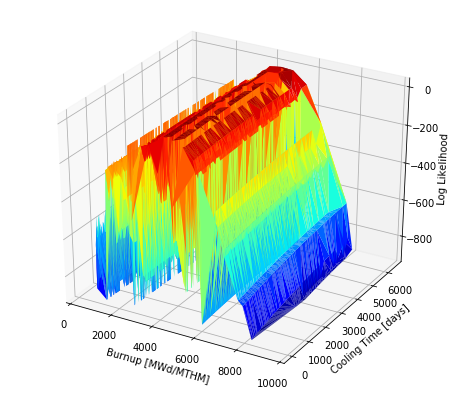

In [45]:
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = plotXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap='jet')
#ax.scatter(x, y, z, marker='.', s=5, c='black', alpha=0.2)
#ax.view_init(elev=50, azim=-25)

ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
ax.set_xlim(0, 10000)
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [22]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [23]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
X.shape

(14629, 16)

In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 27681.316033
         Iterations: 3281
         Function evaluations: 4470
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -4.0495e+08
Model:                        NormMod   AIC:                         8.099e+08
Method:            Maximum Likelihood   BIC:                         8.099e+08
Date:                Mon, 26 Aug 2019                                         
Time:                        12:40:39                                         
No. Observations:               14629                                         
Df Residuals:                   14613                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
test_sample.insert(0, 'const', 1.0)
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(1525.3473756144888, 43552    1604.81
 Name: Burnup, dtype: float64)